In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm  # for progress bar

# Read only first N rows to understand structure
print("=== Peek at Data Structure ===")
df_sample = pd.read_csv('../data/raw/complaints.csv', nrows=1000)
print(f"Sample shape: {df_sample.shape}")
print(f"Columns: {df_sample.columns.tolist()}")
print("\nFirst few rows:")
print(df_sample.head())

# Save the column names for later
columns = df_sample.columns.tolist()

=== Peek at Data Structure ===
Sample shape: (1000, 18)
Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']

First few rows:
  Date received                                            Product  \
0    2025-06-20  Credit reporting or other personal consumer re...   
1    2025-06-20                                    Debt collection   
2    2025-06-20  Credit reporting or other personal consumer re...   
3    2025-06-20  Credit reporting or other personal consumer re...   
4    2025-06-20  Credit reporting or other personal consumer re...   

               Sub-product                                 Issue  \
0         Credit reporting  Incorrect information on your report   
1  Telecommunications debt     Atte

In [12]:
# Analyze file without loading all
print("\n=== File Analysis ===")

# Count total rows without loading
import subprocess
result = subprocess.run(['wc', '-l', '../data/raw/complaints.csv'], 
                       capture_output=True, text=True)
total_lines = int(result.stdout.split()[0]) - 1  # minus header
print(f"Total rows in file: {total_lines:,}")

# Check file size
import os
file_size = os.path.getsize('../data/raw/complaints.csv') / (1024**3)
print(f"File size: {file_size:.2f} GB")


=== File Analysis ===
Total rows in file: 17,536,785
File size: 5.63 GB



=== Filtering Data in Chunks ===
Starting to process data in chunks of 50,000 rows...
  Processed 250,000 rows so far...
  Processed 500,000 rows so far...
  Processed 750,000 rows so far...
  Processed 1,000,000 rows so far...
  Processed 1,250,000 rows so far...
  Processed 1,500,000 rows so far...
  Processed 1,750,000 rows so far...
  Processed 2,000,000 rows so far...
  Processed 2,250,000 rows so far...
  Processed 2,500,000 rows so far...
  Processed 2,750,000 rows so far...
  Processed 3,000,000 rows so far...
  Processed 3,250,000 rows so far...
  Processed 3,500,000 rows so far...
  Processed 3,750,000 rows so far...
  Processed 4,000,000 rows so far...
  Processed 4,250,000 rows so far...
  Processed 4,500,000 rows so far...
  Processed 4,750,000 rows so far...
  Processed 5,000,000 rows so far...
  Processed 5,250,000 rows so far...
  Processed 5,500,000 rows so far...
  Processed 5,750,000 rows so far...
  Processed 6,000,000 rows so far...
  Processed 6,250,000 rows so f

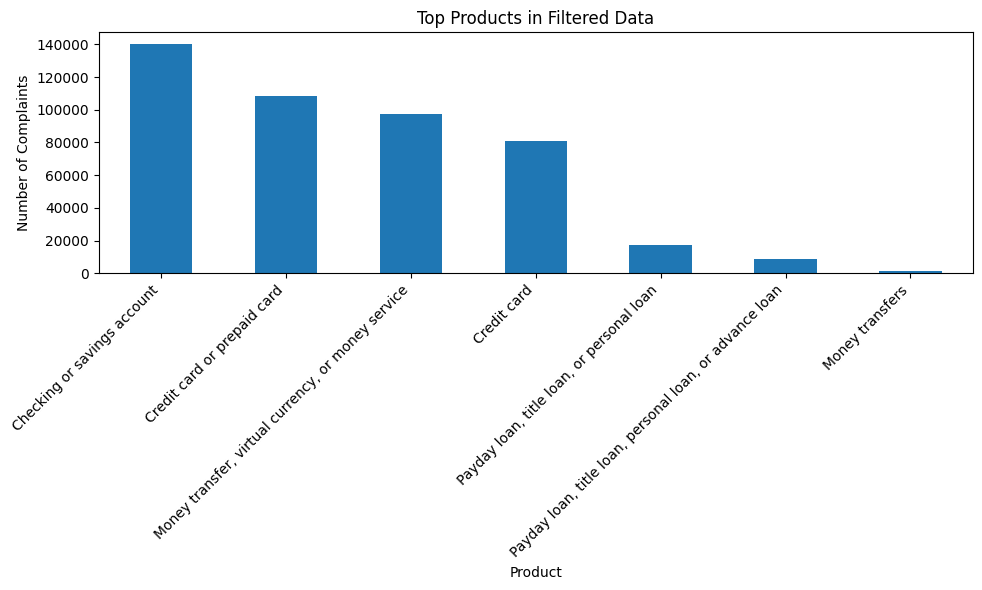


 Sample of filtered data:
                       Product  \
0                  Credit card   
1  Checking or savings account   
2                  Credit card   
3                  Credit card   
4                  Credit card   

                        Consumer complaint narrative  
0  A XXXX XXXX card was opened under my name by a...  
1  I made the mistake of using my wellsfargo debi...  
2  Dear CFPB, I have a secured credit card with c...  
3  I have a Citi rewards cards. The credit balanc...  
4  b'I am writing to dispute the following charge...  


In [15]:
print("\n=== Filtering Data in Chunks ===")

# Define  the 4 products 
target_products = [
    'Credit card',
    'Personal loan',
    'Savings account',
    'Money transfers'
]

# Create an empty list to store filtered chunks
filtered_chunks = []

# Read the file in chunks
chunk_size = 50000  # Process 50,000 rows at a time
chunk_iterator = pd.read_csv('../data/raw/complaints.csv', 
                            chunksize=chunk_size,
                            low_memory=False)  # Important!

total_processed = 0
filtered_count = 0
chunks_processed = 0

print(f"Starting to process data in chunks of {chunk_size:,} rows...")

for chunk in chunk_iterator:
    total_processed += len(chunk)
    chunks_processed += 1
    
    # Show progress every 5 chunks
    if chunks_processed % 5 == 0:
        print(f"  Processed {total_processed:,} rows so far...")
    
    # 1. Keep only rows with narrative
    # FIX: Use .loc to avoid the warning
    chunk = chunk.loc[chunk['Consumer complaint narrative'].notna()].copy()
    
    if len(chunk) == 0:
        continue  # Skip if no narratives in this chunk
    
    # 2. Filter for our products (case-insensitive)
    if 'Product' in chunk.columns:
        # FIX: Use .loc to modify the column
        chunk = chunk.copy()  # Make a copy to avoid warning
        chunk.loc[:, 'Product_lower'] = chunk['Product'].str.lower().str.strip()
        
        # Create filter mask for our 4 products
        # FIX: Better pattern matching
        patterns = [
            'credit card', 'credit card,', 'creditcard',
            'personal loan', 'personalloan',
            'savings account', 'savingsaccount',
            'money transfer', 'moneytransfer'
        ]
        
        pattern = '|'.join(patterns)
        mask = chunk['Product_lower'].str.contains(pattern, case=False, na=False, regex=True)
        
        filtered_chunk = chunk[mask]
        
        if len(filtered_chunk) > 0:
            # Drop the temporary column
            filtered_chunk = filtered_chunk.drop(columns=['Product_lower'])
            filtered_chunks.append(filtered_chunk)
            filtered_count += len(filtered_chunk)
    

print(f"\n Processing complete!")
print(f"   Total rows scanned: {total_processed:,}")
print(f"   Relevant rows found: {filtered_count:,}")
print(f"   Percentage kept: {(filtered_count/total_processed*100):.2f}%")

# Combine all filtered chunks
if filtered_chunks:
    filtered_df = pd.concat(filtered_chunks, ignore_index=True)
    print(f"\n Final filtered dataset shape: {filtered_df.shape}")
    
    # Show product distribution
    print("\n Product Distribution in filtered data:")
    if 'Product' in filtered_df.columns:
        product_counts = filtered_df['Product'].value_counts()
        print(product_counts)
        
        # Visualize
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        product_counts.head(10).plot(kind='bar')
        plt.title('Top Products in Filtered Data')
        plt.xlabel('Product')
        plt.ylabel('Number of Complaints')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('filtered_product_distribution.png')
        plt.show()
    
    # Show sample of data
    print("\n Sample of filtered data:")
    print(filtered_df[['Product', 'Consumer complaint narrative']].head())
    
else:
    print("\n No matching data found!")
    # Create empty dataframe with right columns
    filtered_df = pd.DataFrame(columns=columns)
    print("Created empty dataframe for continuation")


===Exploratory Data Analysis ===

1. Product Distribution:
Product
Checking or savings account                                140319
Credit card or prepaid card                                108667
Money transfer, virtual currency, or money service          97188
Credit card                                                 80667
Payday loan, title loan, or personal loan                   17238
Payday loan, title loan, personal loan, or advance loan      8896
Money transfers                                              1497
Name: count, dtype: int64


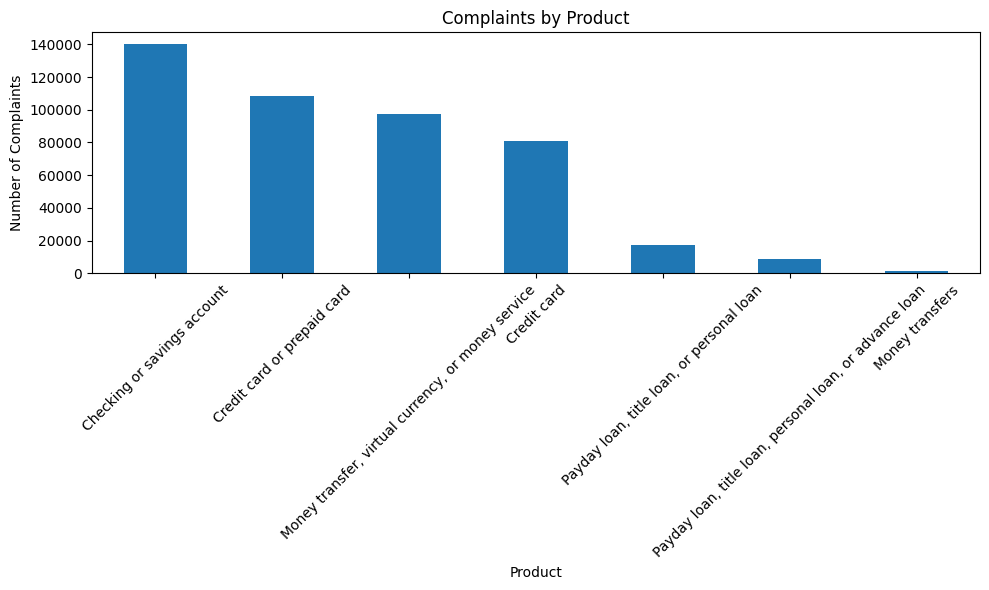


2. Narrative Length Analysis:
Average length: 1140 characters
Min length: 4
Max length: 32959


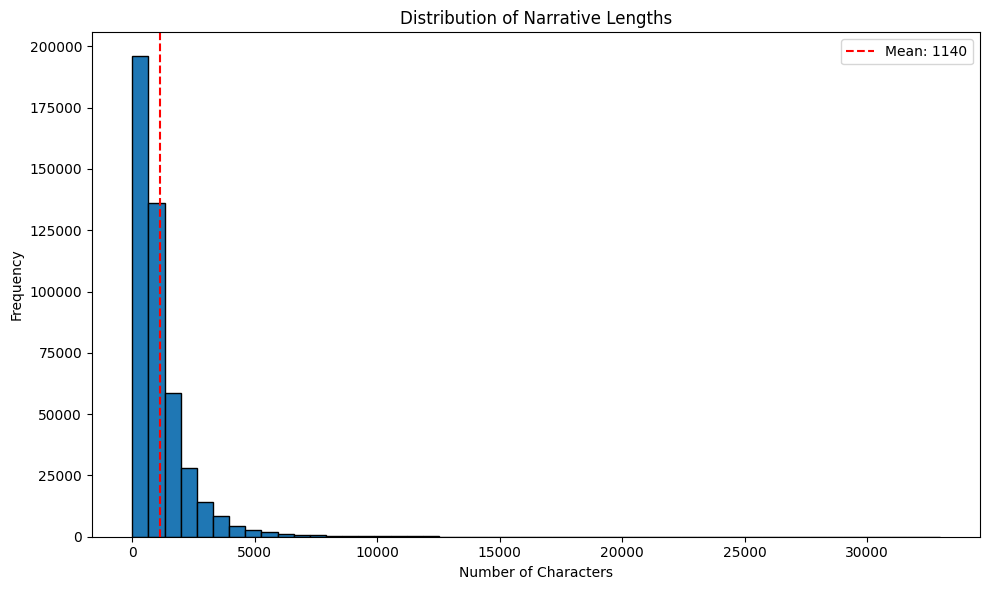


3. Missing Values Check:
Sub-product                 18873
Sub-issue                  143596
Company public response    272864
State                        5388
Tags                       374206
Consumer disputed?         434138
dtype: int64

4. Date Analysis:
Date range: 2015-03-19 00:00:00 to 2025-06-15 00:00:00


In [16]:
print("\n===Exploratory Data Analysis ===")

# 1. Product distribution
print("\n1. Product Distribution:")
product_counts = filtered_df['Product'].value_counts()
print(product_counts)

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
product_counts.plot(kind='bar')
plt.title('Complaints by Product')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('product_distribution.png')
plt.show()

# 2. Narrative length analysis
print("\n2. Narrative Length Analysis:")
filtered_df['narrative_length'] = filtered_df['Consumer complaint narrative'].str.len()
print(f"Average length: {filtered_df['narrative_length'].mean():.0f} characters")
print(f"Min length: {filtered_df['narrative_length'].min()}")
print(f"Max length: {filtered_df['narrative_length'].max()}")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['narrative_length'], bins=50, edgecolor='black')
plt.title('Distribution of Narrative Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.axvline(filtered_df['narrative_length'].mean(), color='red', linestyle='--', 
           label=f'Mean: {filtered_df["narrative_length"].mean():.0f}')
plt.legend()
plt.tight_layout()
plt.savefig('narrative_length_distribution.png')
plt.show()

# 3. Check for missing values
print("\n3. Missing Values Check:")
missing_values = filtered_df.isnull().sum()
print(missing_values[missing_values > 0])

# 4. Date analysis
if 'Date received' in filtered_df.columns:
    print("\n4. Date Analysis:")
    filtered_df['Date received'] = pd.to_datetime(filtered_df['Date received'], errors='coerce')
    print(f"Date range: {filtered_df['Date received'].min()} to {filtered_df['Date received'].max()}")

In [18]:
print("\n=== Text Cleaning ===")

def clean_text_enhanced(text):
    """
    Enhanced cleaning for complaint narratives
    """
    if pd.isna(text):
        return ""
    
    # Convert to string
    text = str(text)
    
    # Remove common boilerplate phrases with regex for better matching
    boilerplate_patterns = [
        r'i\s+am\s+writing\s+to\s+file\s+a\s+complaint',
        r'this\s+is\s+a\s+formal\s+complaint',
        r'dear\s+sir/madam',
        r'to\s+whom\s+it\s+may\s+concern',
        r'cc:\s*consumer\s*financial\s*protection\s*bureau',
        r'cfpb\s*reference',
        r'complaint\s*id:?\s*\d+',
        r'date\s*of\s*complaint:?\s*\d{1,2}/\d{1,2}/\d{4}',
    ]
    
    import re
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    # Handle XXXX redactions (common in CFPB data)
    # Option 1: Remove XXXX entirely
    text = re.sub(r'\bXXXX\b', '', text)
    
    # Option 2: Or replace with [REDACTED] for clarity
    # text = re.sub(r'\bXXXX\b', '[REDACTED]', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+\.\S+', '[EMAIL]', text)
    
    # Remove phone numbers
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '[PHONE]', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '[URL]', text)
    
    # Remove account numbers (patterns like ####-####-####-####)
    text = re.sub(r'\b\d{4}[- ]?\d{4}[- ]?\d{4}[- ]?\d{4}\b', '[ACCOUNT]', text)
    
    # Remove SSN-like patterns
    text = re.sub(r'\b\d{3}[- ]?\d{2}[- ]?\d{4}\b', '[SSN]', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters but keep basic punctuation and letters
    text = re.sub(r'[^\w\s.,!?\-:;\'"()]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    return text

# Apply enhanced cleaning
print("Applying enhanced cleaning...")
filtered_df['cleaned_narrative_enhanced'] = filtered_df['Consumer complaint narrative'].apply(clean_text_enhanced)

# Compare results
print("\n=== Cleaning Comparison ===")
print("Original (first 200 chars):")
print(filtered_df['Consumer complaint narrative'].iloc[0][:200])
print("\nBasic cleaning (your version):")
print(filtered_df['cleaned_narrative'].iloc[0][:200])
print("\nEnhanced cleaning (new version):")
print(filtered_df['cleaned_narrative_enhanced'].iloc[0][:200])

# Check another sample
print("\n" + "="*50)
print("Second sample comparison:")
print("Original:")
print(filtered_df['Consumer complaint narrative'].iloc[1][:200] if len(filtered_df) > 1 else "Not enough data")
if len(filtered_df) > 1:
    print("\nEnhanced cleaning:")
    print(filtered_df['cleaned_narrative_enhanced'].iloc[1][:200])


=== Text Cleaning ===
Applying enhanced cleaning...

=== Cleaning Comparison ===
Original (first 200 chars):
A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unaut

Basic cleaning (your version):
a xxxx xxxx card was opened under my name by a fraudster. i received a notice from xxxx that an account was just opened under my name. i reached out to xxxx xxxx to state that this activity was unauth

Enhanced cleaning (new version):
a card was opened under my name by a fraudster. i received a notice from that an account was just opened under my name. i reached out to to state that this activity was unauthorized and not me. confir

Second sample comparison:
Original:
I made the mistake of using my wellsfargo debit card to depsit funds Into XXXXXXXX ATM machine outside their branch. 

I went into the branch and was told they couldn't help and had to

In [19]:
print("\n=== Cleaning Statistics ===")

# Calculate text length before and after
filtered_df['original_length'] = filtered_df['Consumer complaint narrative'].str.len()
filtered_df['cleaned_length'] = filtered_df['cleaned_narrative_enhanced'].str.len()
filtered_df['reduction_percent'] = ((filtered_df['original_length'] - filtered_df['cleaned_length']) / filtered_df['original_length'] * 100).round(2)

print(f"Average original length: {filtered_df['original_length'].mean():.0f} characters")
print(f"Average cleaned length: {filtered_df['cleaned_length'].mean():.0f} characters")
print(f"Average reduction: {filtered_df['reduction_percent'].mean():.1f}%")

# Check for empty narratives after cleaning
empty_after_cleaning = (filtered_df['cleaned_narrative_enhanced'].str.strip() == '').sum()
print(f"\nNarratives that became empty after cleaning: {empty_after_cleaning} ({empty_after_cleaning/len(filtered_df)*100:.2f}%)")

# Remove rows that became empty
if empty_after_cleaning > 0:
    print(f"Removing {empty_after_cleaning} rows that became empty after cleaning...")
    filtered_df = filtered_df[filtered_df['cleaned_narrative_enhanced'].str.strip() != '']
    print(f"New dataset shape: {filtered_df.shape}")


=== Cleaning Statistics ===
Average original length: 1140 characters
Average cleaned length: 1089 characters
Average reduction: 4.0%

Narratives that became empty after cleaning: 3 (0.00%)
Removing 3 rows that became empty after cleaning...
New dataset shape: (454469, 24)


In [20]:
print("\n=== Save Processed Data ===")

# Save the fully cleaned data
output_path = '../data/processed/cleaned_complaints.csv'

# Select columns to save
columns_to_save = [
    'Product',
    'Consumer complaint narrative',  # Original
    'cleaned_narrative_enhanced',    # Cleaned version
    'original_length',
    'cleaned_length',
    'reduction_percent'
]

# Add any other columns that exist
for col in ['Issue', 'Sub-issue', 'Company', 'State', 'Date received']:
    if col in filtered_df.columns:
        columns_to_save.append(col)

# Save to CSV
filtered_df[columns_to_save].to_csv(output_path, index=False)
print(f" Saved {len(filtered_df):,} cleaned complaints to: {output_path}")
print(f"   File size: {os.path.getsize(output_path) / (1024**2):.2f} MB")

# Also save a sample for testing
sample_size = min(1000, len(filtered_df))
sample_df = filtered_df.sample(n=sample_size, random_state=42)[['Product', 'cleaned_narrative_enhanced']]
sample_path = '../data/processed/cleaned_complaints_sample.csv'
sample_df.to_csv(sample_path, index=False)
print(f" Saved {sample_size} row sample to: {sample_path}")

# Show sample of saved data
print("\n Sample of saved data:")
print(sample_df.head())


=== Save Processed Data ===
 Saved 454,469 cleaned complaints to: ../data/processed/cleaned_complaints.csv
   File size: 1030.52 MB
 Saved 1000 row sample to: ../data/processed/cleaned_complaints_sample.csv

 Sample of saved data:
                                                  Product  \
193730                        Checking or savings account   
329287  Money transfer, virtual currency, or money ser...   
140347                        Checking or savings account   
422614                        Checking or savings account   
65062                         Checking or savings account   

                               cleaned_narrative_enhanced  
193730  my account was frozen with my money in the acc...  
329287  i bank-wired 3000.00 usd to coinbase , inc. on...  
140347  on xxxx2021 i requested to close my account wi...  
422614  on xxxxyear i requested a 12000.00 withdrawal ...  
65062   fifth third ba m continues to charge me excess...  


In [21]:
print("\n=== Generate Cleaning Summary ===")

# Create summary statistics
summary_stats = {
    'total_complaints': len(filtered_df),
    'avg_original_length': filtered_df['original_length'].mean(),
    'avg_cleaned_length': filtered_df['cleaned_length'].mean(),
    'avg_reduction_percent': filtered_df['reduction_percent'].mean(),
    'products_count': filtered_df['Product'].nunique(),
    'unique_companies': filtered_df['Company'].nunique() if 'Company' in filtered_df.columns else 0,
}

# Generate markdown report
report = f"""
# Text Cleaning Summary Report

## Overview
- **Total complaints processed**: {summary_stats['total_complaints']:,}
- **Average original length**: {summary_stats['avg_original_length']:.0f} characters
- **Average cleaned length**: {summary_stats['avg_cleaned_length']:.0f} characters
- **Average size reduction**: {summary_stats['avg_reduction_percent']:.1f}%

## Cleaning Operations Performed
1. **Lowercasing**: All text converted to lowercase
2. **Boilerplate removal**: Standard complaint phrases removed
3. **Redaction handling**: XXXX placeholders processed
4. **PII removal**: Email, phone, SSN patterns replaced
5. **Special character removal**: Non-alphanumeric characters cleaned
6. **Whitespace normalization**: Multiple spaces reduced to single spaces

## Product Distribution After Cleaning
{filtered_df['Product'].value_counts().to_string()}

## Sample Before/After Cleaning

### Sample 1:
**Before**: {filtered_df['Consumer complaint narrative'].iloc[0][:150]}...
**After**: {filtered_df['cleaned_narrative_enhanced'].iloc[0][:150]}...

### Sample 2:
**Before**: {filtered_df['Consumer complaint narrative'].iloc[1][:150] if len(filtered_df) > 1 else 'N/A'}...
**After**: {filtered_df['cleaned_narrative_enhanced'].iloc[1][:150] if len(filtered_df) > 1 else 'N/A'}...

## Next Steps
The cleaned narratives are now ready for:
1. **Text chunking** (Task 2)
2. **Embedding generation**
3. **Vector store indexing**
"""

# Save report
with open('text_cleaning_report.md', 'w') as f:
    f.write(report)

print(" Generated text_cleaning_report.md")
print("\nSummary:")
print(f"   Total complaints: {summary_stats['total_complaints']:,}")
print(f"   Size reduction: {summary_stats['avg_reduction_percent']:.1f}%")
print(f"   Saved to: {output_path}")


=== Generate Cleaning Summary ===
 Generated text_cleaning_report.md

Summary:
   Total complaints: 454,469
   Size reduction: 4.0%
   Saved to: ../data/processed/cleaned_complaints.csv



=== Visualizations ===


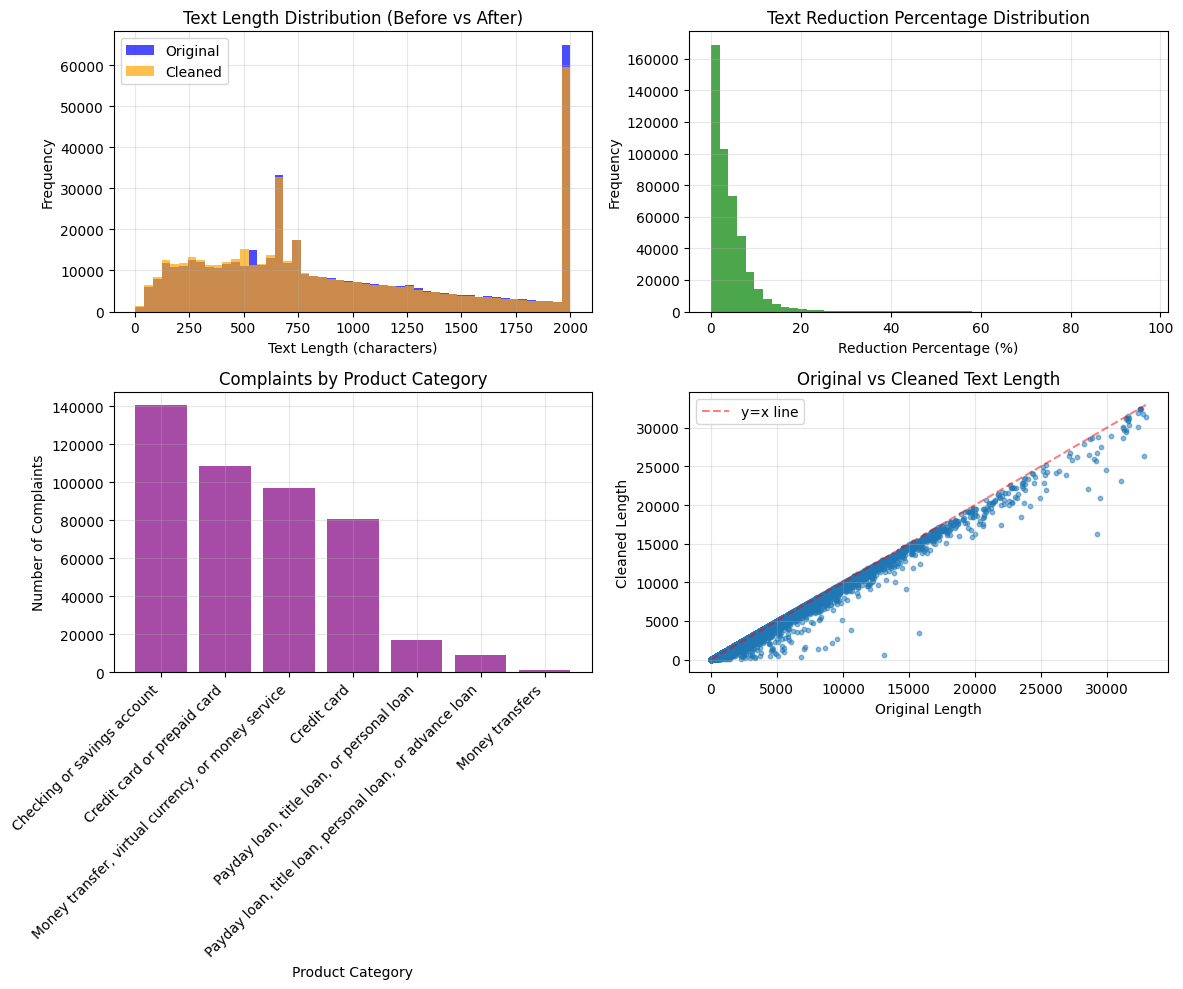

 Saved visualization to: cleaning_visualizations.png


In [22]:
print("\n=== Visualizations ===")

import matplotlib.pyplot as plt

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Text length distribution before/after
axes[0, 0].hist(filtered_df['original_length'].clip(upper=2000), bins=50, alpha=0.7, label='Original', color='blue')
axes[0, 0].hist(filtered_df['cleaned_length'].clip(upper=2000), bins=50, alpha=0.7, label='Cleaned', color='orange')
axes[0, 0].set_xlabel('Text Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Text Length Distribution (Before vs After)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Reduction percentage distribution
axes[0, 1].hist(filtered_df['reduction_percent'], bins=50, color='green', alpha=0.7)
axes[0, 1].set_xlabel('Reduction Percentage (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Text Reduction Percentage Distribution')
axes[0, 1].grid(True, alpha=0.3)

# 3. Product distribution
product_counts = filtered_df['Product'].value_counts()
axes[1, 0].bar(range(len(product_counts)), product_counts.values, color='purple', alpha=0.7)
axes[1, 0].set_xticks(range(len(product_counts)))
axes[1, 0].set_xticklabels(product_counts.index, rotation=45, ha='right')
axes[1, 0].set_xlabel('Product Category')
axes[1, 0].set_ylabel('Number of Complaints')
axes[1, 0].set_title('Complaints by Product Category')
axes[1, 0].grid(True, alpha=0.3)

# 4. Scatter plot: Original vs Cleaned length
axes[1, 1].scatter(filtered_df['original_length'], filtered_df['cleaned_length'], alpha=0.5, s=10)
axes[1, 1].plot([0, filtered_df['original_length'].max()], [0, filtered_df['original_length'].max()], 
                'r--', alpha=0.5, label='y=x line')
axes[1, 1].set_xlabel('Original Length')
axes[1, 1].set_ylabel('Cleaned Length')
axes[1, 1].set_title('Original vs Cleaned Text Length')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cleaning_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Saved visualization to: cleaning_visualizations.png")